In [1]:
# Standard Library
import datetime
import os
from pathlib import Path

# Third Party Library
import joblib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from scipy.stats import rankdata
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler

# First Party Library
from src.visualization.plot import (
    image_concat_and_imshow,
    scatter_each_classes,
)

In [2]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markers = ['s', 'D', 'o', 'p', '*', 'h', 'D', '8', 'v', 'x']

model_name = "SimpleCAE64"
extractor_trained_datetime = "2023-01-31/12-54-00"
vbgmm_trained_dataetime = "2023-02-06/16-36-04"

project_dir = Path("/home/shinsei/MyResearchs/feat_extrc")

model_save_pardir = project_dir / "models" / "VBGMM"
feature_pardir = project_dir / "reports" / "features" / model_name / extractor_trained_datetime
figure_pardir = project_dir / "reports" / "figures" / "VBGMM" / extractor_trained_datetime
image_pardir = project_dir / "data" / "processed" / "CNTForest" / "cnt_sem_64x64" / "10k" 
vbgmm_model_path = model_save_pardir / vbgmm_trained_dataetime / "vbgmm_pca_39_10clusters.pkl"

# feature_csv_path = "/home/shinsei/MyResearchs/feat_extrc/reports/features/SimpleCAE32/2023-07-07/12-15-24/features.csv"
feature_train_csv_path = feature_pardir / "old" / "features_train_data.csv"
feature_check_csv_path = feature_pardir / "old" / "features_check_data.csv"
feature_check_cl_csv_path = feature_pardir / "old" / "features_check_data_clustering.csv"

In [3]:
feature_train_csv_path

PosixPath('/home/shinsei/MyResearchs/feat_extrc/reports/features/SimpleCAE64/2023-01-31/12-54-00/old/features_train_data.csv')

In [4]:
df_train = pl.read_csv(feature_train_csv_path)
X_train = df_train.select([
    pl.exclude(["filename", "dirname", "image_class"])
]).to_numpy()
df_train.head()

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,…,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,filename,dirname,image_class
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,i64
-0.9269,0.843265,0.6126624,-0.277512,0.298505,1.001531,0.02903,-0.34128,0.3420833,0.587049,0.206476,-0.267592,-0.528104,0.494428,-0.826969,0.483574,-0.166025,0.8276705,-0.505435,0.733588,0.38192,-0.361183,-0.271659,-0.480405,-0.769999,0.209984,-0.616336,0.177383,0.568735,0.209394,1.2970613,0.4737064,-0.29061,0.089626,0.312676,0.279553,-0.599722,…,0.3078473,0.1977,0.408677,0.9971671,0.8917413,0.28426,0.926035,0.428953,-0.541066,-0.810948,-0.321705,-1.21333,0.757743,-0.878233,-0.184991,-0.094914,-0.346697,0.60077,0.64347,0.5355,1.365926,0.353756,0.7322836,0.286617,0.093655,0.193874,0.087921,0.6119767,0.096289,0.826081,0.5515343,0.058248,0.480276,-0.265653,"""10k_1_0000.png…",1,1
-0.009947,0.927548,1.1505102,-0.624632,0.397639,-0.122919,0.85256,0.543366,0.231725,-0.447981,0.550507,-0.276664,0.079602,-0.392944,0.091095,0.182105,-0.355953,0.270898,-0.454523,-0.947334,0.664137,-0.391767,0.5322991,0.441308,0.166664,1.1945963,0.026689,1.5033779,0.106618,0.443194,0.3623721,0.5812999,0.232328,-0.981241,0.7157615,-0.574305,-0.272579,…,0.042069,-0.234469,0.5631842,0.361504,0.054867,0.350992,0.453993,0.292604,0.262641,-0.637069,-1.049014,0.130382,0.3367461,-0.486937,0.053197,-0.316327,0.029273,1.2524853,0.437774,-0.874009,0.1411314,0.081975,0.6954319,0.802413,0.7032233,-0.033554,-0.469536,0.456567,0.5313166,0.5451928,0.6624934,-0.83147,0.082701,0.244025,"""10k_1_0001.png…",1,1
-0.24909,0.7486207,0.356954,-0.068873,0.5551213,0.105514,0.0313746,0.6457776,0.5125199,-0.915948,-0.392567,0.6921034,-0.256929,0.3754861,0.914978,0.057196,0.402772,0.315691,1.2643617,-0.76552,-0.755005,0.3225675,-0.805229,-0.466812,-0.084814,0.23996,0.9808978,0.547777,0.203696,0.385044,0.166226,0.237675,-0.360935,0.443557,1.0492125,0.7579856,1.3506186,…,-0.19908,0.125316,0.0403955,0.044245,0.6812006,-0.838184,0.7945914,0.544206,0.7106812,-0.105143,0.278747,-0.591592,-0.440019,0.037675,-0.330602,-0.235434,0.213895,0.6670591,-0.169985,0.6717272,0.978547,0.122732,0.07503,0.986523,0.42992,-0.319217,-0.234249,0.036453,0.5092412,0.6665644,-0.049584,0.439987,0.522707,0.313991,"""10k_1_0002.png…",1,1
0.008232,-1.202079,0.5091924,0.8315466,0.6650882,-0.467229,-0.884164,0.597264,-0.407771,-0.595748,0.280753,0.3451414,0.283581,0.8283184,-0.776521,-0.328458,-0.78586,0.43337,0.3106391,0.3975072,0.6148094,0.161519,-0.320786,-0.303463,-0.267235,0.734457,0.393824,0.721987,-0.790877,0.4815862,0.032031,-0.203372,0.664768,1.170238,1.2051961,-0.359037,0.377196,…,-0.259893,0.5005944,0.177765,0.046342,0.846276,0.762177,-0.031565,0.1638139,0.183275,0.50012,0.080403,-0.302736,0.094618,0.094361,0.366617,-0.80209,-0.464648,0.324706,0.319175,0.347321,0.280997,0.374896,0.290573,0.322082,-0.336496,0.871359,1.4805689,0.933898,0.318906,0.255928,0.300701,0.797695,0.4677705,-0.639196,"""10k_1_0003.png…",1,1
0.580264,-0.633204,0.157098,0.7252918,0.9479,0.507724,0.6972761,0.683109,0.3009678,-0.630001,0.8122193,0.380342,0.109659,0.8707747,1.1453618,1.1660368,-0.443006,-0.297383,0.152454,-0.916478,-0.078569,0.485374,0.1890351,-0.120561,0.068986,0.218009,0.16324,0.393099,-0.400901,0.5898986,-0.143783,-0.746401,1.9208477,-0.889737,0.565096,-0.194857,-0.20528,…,0.5360277,-0.209123,0.021978,0.149037,0.005934,0.8946987,-0.333069,0.502923,0.206365,-0.584492,-0.547253,0.217616,-0.432015,-0.552526,0.294888,0.265745,1.1682152,0.5331968,0.197492,0.077333,0.465878,-0.018743,0.47207,0.192187,0.693555,0.068284,0.7856639,0.9024386,-0.164243,0.229414,0.269972,0.285468,

In [5]:
df_check = pl.read_csv(feature_check_csv_path)
X_check = df_check.select([
    pl.exclude(["filename", "dirname", "image_class"])
]).to_numpy()
df_check.head()

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,…,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,filename,dirname,image_class
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,i64
0.151968,0.074344,1.1429887,0.6482391,0.8312619,-0.458295,-0.470163,0.4421803,0.308007,0.487585,0.079386,-0.603944,-0.484162,-0.55106,-0.200968,0.249687,-0.141033,0.428824,0.6745352,1.0379769,0.61666,-0.613746,-0.328035,0.4435561,-0.683461,0.5821615,-0.488161,0.8589369,-0.1746,-1.157131,1.2412136,0.061115,0.084585,-0.263467,0.699179,-1.011254,-0.873451,…,-0.085664,-0.830469,0.146245,-0.639908,0.644558,0.15654,0.388442,0.284115,-0.02908,0.5871443,-0.266376,-0.423537,0.693534,0.8495269,0.522514,0.011287,0.5027473,0.2321126,0.442071,1.5058657,1.2930375,0.9415431,0.8915946,0.353327,-0.078918,0.351628,-0.543504,0.15659,0.474218,1.4862473,-0.719533,0.098254,0.342721,-0.200453,"""10k_1_h000_w00…",1,1
0.089995,-1.040233,0.184702,0.1412435,0.459983,0.9290133,0.145317,0.161774,0.376224,0.3411135,1.0541875,-0.304485,0.4888293,0.238397,0.4895274,0.537265,0.397347,-0.592097,0.00394,-0.540936,0.369379,1.0273727,0.8298075,0.6813708,-0.825986,0.175434,-0.553154,-0.871819,-0.011651,-0.307032,-0.170513,-0.602397,0.59617,-0.734808,0.097542,-0.538767,0.88591,…,-0.086073,-0.363437,0.044158,0.2089352,0.355874,-0.046153,-0.327612,-0.842989,0.7762783,0.26134,0.235847,0.344204,-0.964258,0.322002,0.1845954,0.118663,0.2388712,0.418765,0.9342386,0.005011,0.437411,0.125851,0.168601,0.382068,0.6452136,0.045576,1.1755047,-0.265317,0.4188208,-0.024107,-0.032116,-0.168855,0.081913,0.794514,"""10k_1_h000_w00…",1,1
1.0259198,0.000698,0.426111,0.088267,0.306091,0.219862,-0.206673,0.9832614,-0.200843,-0.3264,0.8144838,1.4908165,0.1205611,-0.266459,-0.181501,0.3297372,0.368041,1.2328029,0.263693,-0.555532,0.873296,0.6753092,-0.143553,0.375742,0.032386,0.541304,0.5884077,0.6957742,0.636171,1.0360302,0.053319,-0.053788,-0.701955,-0.335199,0.192395,-1.179171,0.449499,…,0.276685,-0.469699,-0.438581,-0.735988,-0.794822,-0.330874,0.919805,-0.488786,-0.828419,0.1803935,1.0593106,-0.604429,-0.541966,0.26587,0.10207,-0.103866,-0.347935,0.6560879,1.1903052,-0.56222,-0.271618,0.6356947,-0.192958,0.540935,-0.217967,-0.114069,-0.640225,1.0502827,-0.62836,-0.460102,0.6863028,0.135694,0.130569,-0.356638,"""10k_1_h000_w01…",1,1
-0.083992,1.0589097,-0.326704,0.6364554,-0.914625,0.47387,1.0860847,0.521235,0.003672,0.218035,0.6524501,-0.138849,-0.534809,0.6335228,0.288523,0.9676402,-0.290531,0.118395,-0.708857,-0.354443,0.058593,0.7000443,0.557593,-0.169985,-0.071839,-0.444239,-0.839111,-0.662621,0.848421,-0.680229,-0.649597,0.8152479,0.058661,0.176722,0.6165383,0.789668,0.3932037,…,0.385525,0.558848,0.8667203,0.8024541,0.4645407,0.172787,-0.159975,0.039717,0.431427,0.4659576,0.226406,0.8092851,-0.348454,-0.707718,1.4744102,0.523282,-0.66907,0.6191588,0.8634852,0.437077,0.424649,0.372284,0.224895,-0.377953,0.20257,1.5357784,-0.038913,-0.549843,0.3000867,0.414636,-1.285042,-0.316827,0.047535,0.313985,"""10k_1_h000_w01…",1,1
-0.272014,0.7757265,0.203738,0.014765,0.6898008,0.530291,0.058953,0.43193,0.043055,0.9176391,0.99437,-0.724475,-0.060024,-0.812836,0.073931,0.7727371,0.137301,0.270086,0.04564,-1.270428,-0.301318,0.7385617,1.0170226,-0.35308,0.04247,0.4213549,0.554288,0.082038,-0.349314,-0.615952,-0.006838,0.150098,-0.644178,-0.261184,-0.204636,-0.705292,-0.319649,…,0.306595,0.7018244,0.3853131,0.5441954,-0.398346,0.164006,-0.357865,1.0063698,0.568198,0.5367863,0.6955298,0.9888465,0.8528766,0.178272,0.168175,0.1736008,1.3586694,0.53838,0.38865,0.514455,0.7436989,0.433512,0.592727,0.064121,0.7293063,0.013871,0.4963209,-0.836654,0.07

In [6]:

df_check_cl = pl.read_csv(feature_check_cl_csv_path)
X_check_cl = df_check_cl.select([
    pl.exclude(["filename", "dirname", "image_class", "cluster"])
]).to_numpy()
y_check_cl = df_check_cl.select(
    "cluster"
).to_numpy().flatten()
df_check_cl.head()

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,…,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,filename,dirname,image_class,cluster
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,i64,i64
0.151968,0.074344,1.1429887,0.6482391,0.8312619,-0.458295,-0.470163,0.4421803,0.308007,0.487585,0.079386,-0.603944,-0.484162,-0.55106,-0.200968,0.249687,-0.141033,0.428824,0.6745352,1.0379769,0.61666,-0.613746,-0.328035,0.4435561,-0.683461,0.5821615,-0.488161,0.8589369,-0.1746,-1.157131,1.2412136,0.061115,0.084585,-0.263467,0.699179,-1.011254,-0.873451,…,-0.830469,0.146245,-0.639908,0.644558,0.15654,0.388442,0.284115,-0.02908,0.5871443,-0.266376,-0.423537,0.693534,0.8495269,0.522514,0.011287,0.5027473,0.2321126,0.442071,1.5058657,1.2930375,0.9415431,0.8915946,0.353327,-0.078918,0.351628,-0.543504,0.15659,0.474218,1.4862473,-0.719533,0.098254,0.342721,-0.200453,"""10k_1_h000_w00…",1,1,0
0.089995,-1.040233,0.184702,0.1412435,0.459983,0.9290133,0.145317,0.161774,0.376224,0.3411135,1.0541875,-0.304485,0.4888293,0.238397,0.4895274,0.537265,0.397347,-0.592097,0.00394,-0.540936,0.369379,1.0273727,0.8298075,0.6813708,-0.825986,0.175434,-0.553154,-0.871819,-0.011651,-0.307032,-0.170513,-0.602397,0.59617,-0.734808,0.097542,-0.538767,0.88591,…,-0.363437,0.044158,0.2089352,0.355874,-0.046153,-0.327612,-0.842989,0.7762783,0.26134,0.235847,0.344204,-0.964258,0.322002,0.1845954,0.118663,0.2388712,0.418765,0.9342386,0.005011,0.437411,0.125851,0.168601,0.382068,0.6452136,0.045576,1.1755047,-0.265317,0.4188208,-0.024107,-0.032116,-0.168855,0.081913,0.794514,"""10k_1_h000_w00…",1,1,0
1.0259198,0.000698,0.426111,0.088267,0.306091,0.219862,-0.206673,0.9832614,-0.200843,-0.3264,0.8144838,1.4908165,0.1205611,-0.266459,-0.181501,0.3297372,0.368041,1.2328029,0.263693,-0.555532,0.873296,0.6753092,-0.143553,0.375742,0.032386,0.541304,0.5884077,0.6957742,0.636171,1.0360302,0.053319,-0.053788,-0.701955,-0.335199,0.192395,-1.179171,0.449499,…,-0.469699,-0.438581,-0.735988,-0.794822,-0.330874,0.919805,-0.488786,-0.828419,0.1803935,1.0593106,-0.604429,-0.541966,0.26587,0.10207,-0.103866,-0.347935,0.6560879,1.1903052,-0.56222,-0.271618,0.6356947,-0.192958,0.540935,-0.217967,-0.114069,-0.640225,1.0502827,-0.62836,-0.460102,0.6863028,0.135694,0.130569,-0.356638,"""10k_1_h000_w01…",1,1,0
-0.083992,1.0589097,-0.326704,0.6364554,-0.914625,0.47387,1.0860847,0.521235,0.003672,0.218035,0.6524501,-0.138849,-0.534809,0.6335228,0.288523,0.9676402,-0.290531,0.118395,-0.708857,-0.354443,0.058593,0.7000443,0.557593,-0.169985,-0.071839,-0.444239,-0.839111,-0.662621,0.848421,-0.680229,-0.649597,0.8152479,0.058661,0.176722,0.6165383,0.789668,0.3932037,…,0.558848,0.8667203,0.8024541,0.4645407,0.172787,-0.159975,0.039717,0.431427,0.4659576,0.226406,0.8092851,-0.348454,-0.707718,1.4744102,0.523282,-0.66907,0.6191588,0.8634852,0.437077,0.424649,0.372284,0.224895,-0.377953,0.20257,1.5357784,-0.038913,-0.549843,0.3000867,0.414636,-1.285042,-0.316827,0.047535,0.313985,"""10k_1_h000_w01…",1,1,0
-0.272014,0.7757265,0.203738,0.014765,0.6898008,0.530291,0.058953,0.43193,0.043055,0.9176391,0.99437,-0.724475,-0.060024,-0.812836,0.073931,0.7727371,0.137301,0.270086,0.04564,-1.270428,-0.301318,0.7385617,1.0170226,-0.35308,0.04247,0.4213549,0.554288,0.082038,-0.349314,-0.615952,-0.006838,0.150098,-0.644178,-0.261184,-0.204636,-0.705292,-0.319649,…,0.7018244,0.3853131,0.5441954,-0.398346,0.164006,-0.357865,1.0063698,0.568198,0.5367863,0.6955298,0.9888465,0.8528766,0.178272,0.168175,0.1736008,1.3586694,0.53838,0.38865,0.514455,0.7436989,0.433512,0.592727,0.064121,0.7293063,0.013871,0.4963209,-0.836654,0.074221,-0.198135,-0.261274,0.2742486

In [7]:
X_check_cl.shape

(2400, 128)

In [8]:
sc = StandardScaler()
pca = PCA()

X_train_std = sc.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_std)

X_check_std = sc.transform(X_check)
X_check_pca = pca.transform(X_check_std)

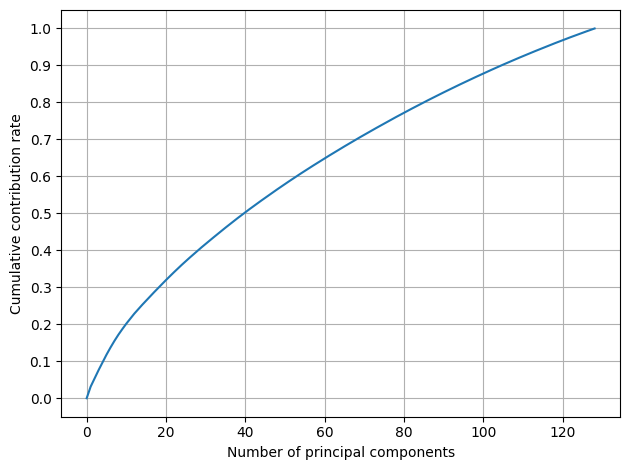

In [9]:
cumsum_contrb_rate = pca.explained_variance_ratio_.cumsum()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(X_train.shape[1]+1), [0]+list(cumsum_contrb_rate))
ax.set_xlabel('Number of principal components')
ax.set_ylabel('Cumulative contribution rate')
ax.set_yticks(np.arange(0., 1.1, 0.1))
ax.grid()
fig.tight_layout()
plt.show()

In [13]:
num_use_features = cumsum_contrb_rate[cumsum_contrb_rate < 0.5].shape[0]
num_use_features

39

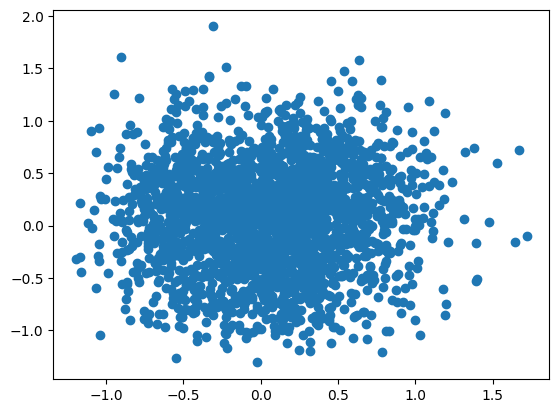

In [10]:
component_01 = df_check_cl.select([pl.col("0"), pl.col("1")]).to_numpy()
plt.scatter(component_01[:, 0], component_01[:, 1])

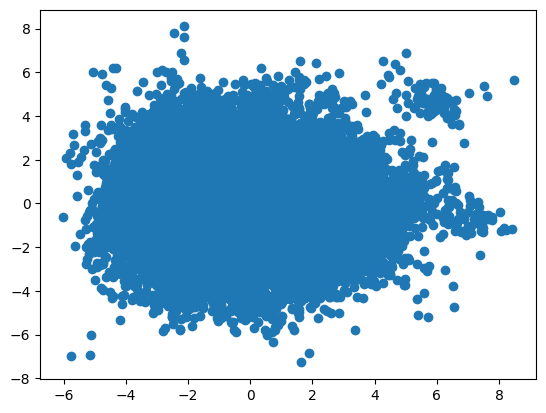

In [11]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])

['s', 'D', 'o', 'p', '*', 'h', 'D', '8', 'v', 'x']
max_abs_range=10.642206617396083


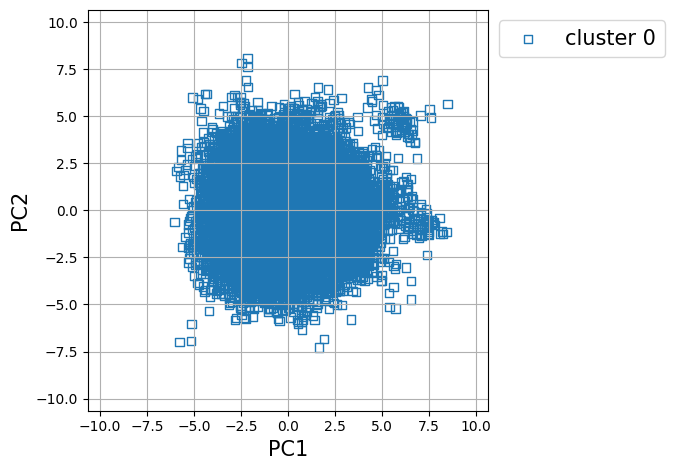

In [12]:
scatter_each_classes(
    X_train_pca,
    [0] * X_train_pca.shape[0],
    [0],
    markers,
    colors="tab10",
    xylabel=("PC1", "PC2"),
    face_color="None",
    fontsize=15
)

In [14]:
vbgmm: BayesianGaussianMixture = joblib.load(vbgmm_model_path)

/home/shinsei/MyResearchs/feat_extrc/.venv/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator BayesianGaussianMixture from version 1.1.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [15]:
y_train_pca = vbgmm.predict(X_train_pca[:, : num_use_features])
y_check_pca = vbgmm.predict(X_check_pca[:, : num_use_features])

In [16]:
X_train.shape

(34048, 128)

In [19]:
np.unique(y_train_pca, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 4406,  2587, 17805,   152,   115,  5247,  3456,   103,    99,
           78]))

In [20]:
hist, edge = np.histogram(y_train_pca, bins=10, range=(0, 10))

In [21]:
rank = rankdata(-hist, "ordinal")

In [32]:
X_train[y_train_pca==9].shape

(8, 129)

['s', 'D', 'o', 'p', '*', 'h', 'D', '8', 'v', 'x']
max_abs_range=10.642206617396083


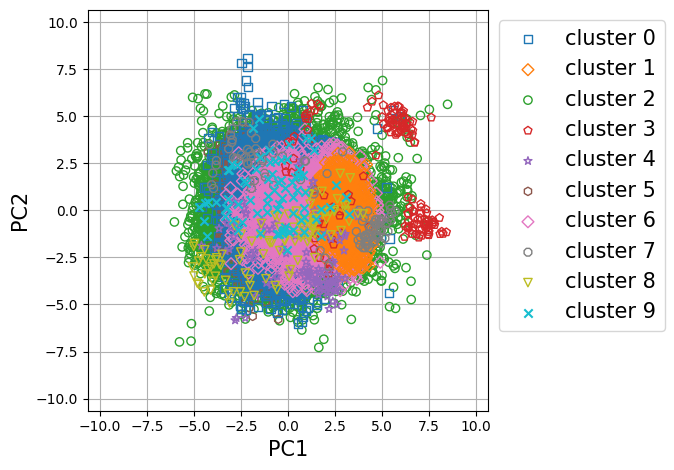

In [22]:
scatter_each_classes(
    X_train_pca,
    y_train_pca,
    rank,
    markers,
    colors="tab10",
    xylabel=("PC1", "PC2"),
    face_color="None",
    fontsize=15
)


In [27]:
filepath_column = pl.concat_str(pl.col("dirname"), pl.col("filename"), separator="/").alias("filepath")
df_train_clustering = df_train.select(
    pl.exclude("image_class")
).with_columns(
    [filepath_column, pl.Series("cluster", y_train_pca)]
)
df_train.head()

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,…,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,filename,dirname,image_class
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,i64
-0.9269,0.843265,0.6126624,-0.277512,0.298505,1.001531,0.02903,-0.34128,0.3420833,0.587049,0.206476,-0.267592,-0.528104,0.494428,-0.826969,0.483574,-0.166025,0.8276705,-0.505435,0.733588,0.38192,-0.361183,-0.271659,-0.480405,-0.769999,0.209984,-0.616336,0.177383,0.568735,0.209394,1.2970613,0.4737064,-0.29061,0.089626,0.312676,0.279553,-0.599722,…,0.3078473,0.1977,0.408677,0.9971671,0.8917413,0.28426,0.926035,0.428953,-0.541066,-0.810948,-0.321705,-1.21333,0.757743,-0.878233,-0.184991,-0.094914,-0.346697,0.60077,0.64347,0.5355,1.365926,0.353756,0.7322836,0.286617,0.093655,0.193874,0.087921,0.6119767,0.096289,0.826081,0.5515343,0.058248,0.480276,-0.265653,"""10k_1_0000.png…",1,1
-0.009947,0.927548,1.1505102,-0.624632,0.397639,-0.122919,0.85256,0.543366,0.231725,-0.447981,0.550507,-0.276664,0.079602,-0.392944,0.091095,0.182105,-0.355953,0.270898,-0.454523,-0.947334,0.664137,-0.391767,0.5322991,0.441308,0.166664,1.1945963,0.026689,1.5033779,0.106618,0.443194,0.3623721,0.5812999,0.232328,-0.981241,0.7157615,-0.574305,-0.272579,…,0.042069,-0.234469,0.5631842,0.361504,0.054867,0.350992,0.453993,0.292604,0.262641,-0.637069,-1.049014,0.130382,0.3367461,-0.486937,0.053197,-0.316327,0.029273,1.2524853,0.437774,-0.874009,0.1411314,0.081975,0.6954319,0.802413,0.7032233,-0.033554,-0.469536,0.456567,0.5313166,0.5451928,0.6624934,-0.83147,0.082701,0.244025,"""10k_1_0001.png…",1,1
-0.24909,0.7486207,0.356954,-0.068873,0.5551213,0.105514,0.0313746,0.6457776,0.5125199,-0.915948,-0.392567,0.6921034,-0.256929,0.3754861,0.914978,0.057196,0.402772,0.315691,1.2643617,-0.76552,-0.755005,0.3225675,-0.805229,-0.466812,-0.084814,0.23996,0.9808978,0.547777,0.203696,0.385044,0.166226,0.237675,-0.360935,0.443557,1.0492125,0.7579856,1.3506186,…,-0.19908,0.125316,0.0403955,0.044245,0.6812006,-0.838184,0.7945914,0.544206,0.7106812,-0.105143,0.278747,-0.591592,-0.440019,0.037675,-0.330602,-0.235434,0.213895,0.6670591,-0.169985,0.6717272,0.978547,0.122732,0.07503,0.986523,0.42992,-0.319217,-0.234249,0.036453,0.5092412,0.6665644,-0.049584,0.439987,0.522707,0.313991,"""10k_1_0002.png…",1,1
0.008232,-1.202079,0.5091924,0.8315466,0.6650882,-0.467229,-0.884164,0.597264,-0.407771,-0.595748,0.280753,0.3451414,0.283581,0.8283184,-0.776521,-0.328458,-0.78586,0.43337,0.3106391,0.3975072,0.6148094,0.161519,-0.320786,-0.303463,-0.267235,0.734457,0.393824,0.721987,-0.790877,0.4815862,0.032031,-0.203372,0.664768,1.170238,1.2051961,-0.359037,0.377196,…,-0.259893,0.5005944,0.177765,0.046342,0.846276,0.762177,-0.031565,0.1638139,0.183275,0.50012,0.080403,-0.302736,0.094618,0.094361,0.366617,-0.80209,-0.464648,0.324706,0.319175,0.347321,0.280997,0.374896,0.290573,0.322082,-0.336496,0.871359,1.4805689,0.933898,0.318906,0.255928,0.300701,0.797695,0.4677705,-0.639196,"""10k_1_0003.png…",1,1
0.580264,-0.633204,0.157098,0.7252918,0.9479,0.507724,0.6972761,0.683109,0.3009678,-0.630001,0.8122193,0.380342,0.109659,0.8707747,1.1453618,1.1660368,-0.443006,-0.297383,0.152454,-0.916478,-0.078569,0.485374,0.1890351,-0.120561,0.068986,0.218009,0.16324,0.393099,-0.400901,0.5898986,-0.143783,-0.746401,1.9208477,-0.889737,0.565096,-0.194857,-0.20528,…,0.5360277,-0.209123,0.021978,0.149037,0.005934,0.8946987,-0.333069,0.502923,0.206365,-0.584492,-0.547253,0.217616,-0.432015,-0.552526,0.294888,0.265745,1.1682152,0.5331968,0.197492,0.077333,0.465878,-0.018743,0.47207,0.192187,0.693555,0.068284,0.7856639,0.9024386,-0.164243,0.229414,0.269972,0.285468,

In [28]:
df_train_clustering.write_csv(
    feature_pardir / "old" / "features_train_data_clustering.csv"
)